Fit for the zero-point of the TFR, using the slope as calibrated from the Coma cluster in the `Coma-Fuji_KAD.ipynb` notebook.  Galaxies used in this calibration are those with line widths observed in ALFALFA.

In [1]:
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization.wcsaxes import SphericalCircle

from scipy.optimize import minimize

from hyperfit.linfit import LinFit

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from VI_functions import get_cutout

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# Data

## fuji

In [3]:
tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- CORI
#tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Separate fuji data into center and off-center observations

In [4]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [5]:
first_digits = firstdigit(tfuji['TARGETID'])

fuji_centers = tfuji[first_digits == 3]
fuji_axis = tfuji[first_digits != 3]

/tmp/ipykernel_35369/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [6]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

## ALFALFA

Read in our version of the SGA that includes the index value of the galaxy in the ALFALFA data file.  (This file was made with the `ALFALFA_radec_match.py` script, currently living in my (Kelly's) data folder on my local machine.)

In [7]:
ALFALFA = Table.read('../../data/a100.code12.table2.190808.txt', 
                     format='ascii.csv', 
                     include_names=['AGCNr', 'W50', 'sigW'])

ALFALFA[:5]

AGCNr,W50,sigW
int64,int64,int64
105367,274,39
333313,313,20
331060,160,4
331061,260,45
104570,245,6


In [8]:
ALFALFA_dict = {}

for i in range(len(ALFALFA)):
    
    ALFALFA_dict[ALFALFA['AGCNr'][i]] = i

In [9]:
SGA = Table.read('../../data/SGA-2020_ALFALFA.fits')

SGA['ALFALFA_index'].name = 'ALFALFA_AGCNr'

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,ALFALFA_AGCNr
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0,-1
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.544437500000

In [10]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### If an SGA galaxy has at least one observation at its center, set the redshift and HI velocity of that galaxy

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

SGA['V_HI'] = np.nan
SGA['VERR_HI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)
    
    # Set the HI velocity width of this galaxy
    if SGA['ALFALFA_AGCNr'][SGA_idx] >= 0:
        
        ALFALFA_idx = ALFALFA_dict[SGA['ALFALFA_AGCNr'][SGA_idx]]
        
        SGA['V_HI'][SGA_idx] = ALFALFA['W50'][ALFALFA_idx] - 6. # Adjustment from Kourkchi et al. (2020a), Sec. 2.2
        SGA['VERR_HI'][SGA_idx] = ALFALFA['sigW'][ALFALFA_idx]

### Filter SGA to keep only those objects with center observations and HI velocities

In [12]:
HI = np.isfinite(SGA['V_HI'])
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have HI velocities
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][HI & centers]

centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

print('fuji galaxies with HI velocities and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
print('fuji off-center observations in galaxies with HI velocities:', len(axis_dist))

fuji galaxies with HI velocities and good center observations: 315
fuji off-center observations in galaxies with HI velocities: 1089


In [53]:
# Cosmicflows-4 selection criteria: S/N > 10 and Wmx > 64 km/s
SN = SGA['V_HI']/SGA['VERR_HI'] > 10
Wmx = (SGA['V_HI'] - 6) > 64

SGA_ID_CF4 = SGA['SGA_ID'][HI & centers & SN & Wmx]

centers_CF4 = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_CF4)]

print('fuji galaxies with CF4 distances and good center observations:', len(np.unique(centers_CF4['SGA_ID'])))

fuji galaxies with CF4 distances and good center observations: 167


# Calculate the rotational velocities

In [13]:
axis_dist['SKY_FIBER_DIST'] = 0.
axis_dist['SKY_FIBER_DIST_R26'] = 0.
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_dist['RA'][obs_idx], 
                             dec=axis_dist['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_dist['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_dist['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

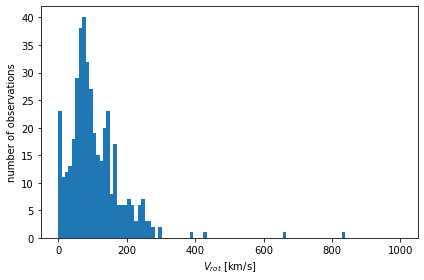

In [14]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_dist['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies with HI velocities suitable for calibrating the TFR

Requirements:
 * $V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [15]:
r0p3 = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = np.abs(axis_dist['V_ROT']) < 1000

good_axis_dist = axis_dist[r0p3 & Vgood]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

314 156


## Inclination angle cut

In [16]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_axis_dist['iSGA'] = -1

for i in range(len(good_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_axis_dist['SGA_ID'][i]]
    
    good_axis_dist['iSGA'][i] = sga_idx
    
good_axis_dist['cosi2'] = SGA['cosi2'][good_axis_dist['iSGA']]

In [17]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_axis_dist['cosi2'] <= cosi2_max

good_edge_axis_dist = good_axis_dist[edge]

print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))

263 131


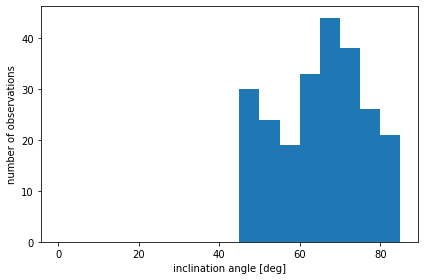

In [18]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_dist['cosi2']))*180/np.pi, bins=np.arange(0, 90, 5))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [19]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

In [20]:
spirals = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals]

print(len(good_edge_spirals_axis_dist), len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

--
--
--
--
--
--
--
--
--
--
227 109


In [21]:
SGA_idx = []

for SGA_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    SGA_idx.append(SGA_dict[SGA_id])

SGA[SGA_idx]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,ALFALFA_AGCNr,Z_DESI,ZERR_DESI,V_HI,VERR_HI,cosi2
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,float64,float64,float64,float64,float32
21905,SGA-2020 21905,PGC2057303,2057303,219.091098,34.9634106,Sc,12.24,0.46881336,0.374973,0.030079473,23.690481,16.707,False,LEDA-20181114,5858,PGC2057303,1,True,219.091098,34.9634106,0.46881336,2191p350,219.09108657904613,34.9633173924782,0.7438286,SB26,9.770802,0.38141513,219.09112462525545,34.96344218485945,16.3721,7.3809056,6.9394255,6.438956,6.945866,9.164333,11.25903,13.091548,14.669391,16.164392,18.16269,19.857664,22.314857,17.193132,16.8005,16.566973,16.881731,16.509058,16.29431,16.72109,16.351477,16.144707,16.604822,16.236557,16.045586,16.522583,16.177313,15.99385,16.47039,16.127832,15.946779,16.435534,16.100458,15.924124,16.417917,16.084673,15.914168,16.399458,16.068775,15.904226,0.12528424,0.1263019,0.15110311,0.12396254,0.17606099,0.17370777,0.21082695,0.13444765,0.27963006,0.041218147,0.04442056,0.047901593,0.036485113,0.038643964,0.04148492,0.033336964,0.0351727,0.03789257,0.03112216,0.03276487,0.03544987,0.029583538,0.031440873,0.034148198,0.028558232,0.030356243,0.033018697,0.027808832,0.02968668,0.032411925,0.027409067,0.029297458,0.03215074,0.026979305,0.028897557,0.03188434,16.368975,0.22579144,6.275678,4.8076715,0.6099423,16.044615,0.22601731,4.7760386,4.7340226,0.24342757,15.884407,0.20401548,4.4418197,4.934887,0.20438476,0,729387,0.0300903938271713,6.8506482821311785e-12,142.0,34.0,0.1098724
25532,SGA-2020 25532,SDSSJ130354.42+281837.9,4107586,195.9767

## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [28]:
for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    print(sga_id)
    
    tf_list = good_edge_spirals_axis_dist[good_edge_spirals_axis_dist['SGA_ID'] == sga_id]
    center_list = centers_dist[centers_dist['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    '''
    # break

21905
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=219.09108657904613&dec=34.9633173924782&zoom=14&layer=ls-dr9&size=174&sga
25532
cache/coma_39628443968603627.jpg exists.
34497
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=150.416765004886&dec=3.2019900406194037&zoom=14&layer=ls-dr9&size=140&sga
71578
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=220.69565216075827&dec=0.6616727207759527&zoom=14&layer=ls-dr9&size=512&sga
74548
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=218.3779230778084&dec=3.6864257707912746&zoom=14&layer=ls-dr9&size=300&sga
176736
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.6326194588143&dec=24.692850662859097&zoom=14&layer=ls-dr9&size=125&sga
180872
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=210.5550679154331&dec=4.095086710695675&zoom=14&layer=ls-dr9&size=151&sga
188525
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=184.18920954546303&dec=-0.1034986259573292&zoom=14&layer=ls-dr9&size=152&sga
19510

In [22]:
VI_remove = Table.read('fuji_ALFALFA_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_dist), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_dist['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_dist = good_edge_spirals_axis_dist[~remove_targets]

print(len(VI_good_edge_spirals_axis_dist), len(np.unique(VI_good_edge_spirals_axis_dist['SGA_ID'])))

227 109


# Zero-point calibration

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \bar{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [23]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))
    
    #good_edge_spirals_axis_dist['R_MAG_SB26'][obs_idx] = SGA['R_MAG_SB26'][SGA_dict[sga_id]]
    #good_edge_spirals_axis_dist['R_MAG_SB26_ERR'][obs_idx] = SGA['R_MAG_SB26_ERR'][SGA_dict[sga_id]]

In [24]:
# Make a catalog of just those galaxies with velocities
SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

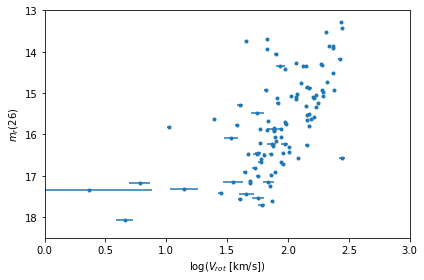

In [25]:
#plt.figure(figsize=(9,5), tight_layout=True)
plt.figure(tight_layout=True)


#plt.subplot(121)
plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_MAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_MAG_SB26_ERR'], 
             fmt='.')

plt.xlim([0, 3])
plt.ylim([18.5, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$')

'''
plt.subplot(122)
plt.errorbar(np.log10(good_edge_spirals_axis_dist['V_ROT']), 
             good_edge_spirals_axis_dist['R_MAG_SB26'], 
             xerr=0.434*good_edge_spirals_axis_dist['V_ROT_ERR']/good_edge_spirals_axis_dist['V_ROT'],
             yerr=good_edge_spirals_axis_dist['R_MAG_SB26_ERR'], 
             fmt='.')

plt.xlim([0, 3])
plt.ylim([18.5, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$')
''';

## Compute the absolute magnitudes based on the distance measurements

### First, we need to correct the HI velocities for the inclination angle.

In [26]:
SGA_0pt['V_HI_corr'] = SGA_0pt['V_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))
SGA_0pt['VERR_HI_corr'] = SGA_0pt['VERR_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))

### Now, we use the Tully-Fisher relation calibrated by Cosmicflows-4 (Kourkchi+ 2020) to calculate the absolute magnitudes of these galaxies

Cosmicflows-4 TF calibration:
\begin{equation}
  \overline{M_\lambda} = \text{Slope} \left( \log W^i_{mx} - 2.5 \right) + \overline{\text{ZP}}
\end{equation}
where
\begin{equation}
  \overline{\text{ZP}} = \text{ZP} + C_{zp}
\end{equation}
is a correction to the zero-point to account for slightly different distance moduli found with different passbands for the same clusters.

For the $r$-band, the parameter values are
 * slope $= -7.96\pm 0.13$
 * ZP $= -20.57\pm 0.10$
 * $C_{zp} = -0.08\pm 0.13$

In [41]:
CF4_slope = -7.96
CF4_slope_err = 0.13

CF4_ZP = -20.57
CF4_ZP_err = 0.10

CF4_Czp = -0.08
CF4_Czp_err = 0.13

SGA_0pt['R_ABSMAG_SB26'] = CF4_slope*(np.log10(SGA_0pt['V_HI_corr'] - 6) - 2.5) + CF4_ZP + CF4_Czp
SGA_0pt['R_ABSMAG_SB26_err'] = np.sqrt((np.log10(SGA_0pt['V_HI_corr'] - 6) - 2.5)**2 * CF4_slope_err**2 + (CF4_slope/((SGA_0pt['V_HI_corr'] - 6)*np.log(10)))**2 * SGA_0pt['VERR_HI_corr']**2 + CF4_ZP_err**2 + CF4_Czp_err**2)

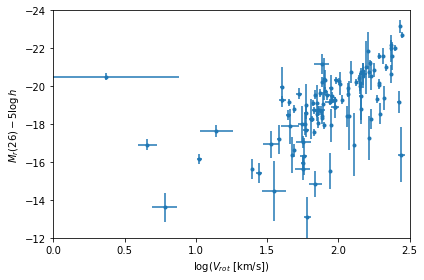

In [42]:
#plt.figure(figsize=(9,5), tight_layout=True)
plt.figure(tight_layout=True)

#plt.subplot(121)
plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_ABSMAG_SB26_err'], 
             fmt='.')

plt.xlim([0, 2.5])
plt.ylim([-12, -24])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$M_r (26) - 5\logh$')

'''
plt.subplot(122)
plt.errorbar(np.log10(good_edge_spirals_axis_dist['V_ROT']), 
             good_edge_spirals_axis_dist['R_ABSMAG_SB26'], 
             xerr=0.434*good_edge_spirals_axis_dist['V_ROT_ERR']/good_edge_spirals_axis_dist['V_ROT'],
             yerr=good_edge_spirals_axis_dist['R_ABSMAG_SB26_err'], 
             fmt='.')

plt.xlim([2, 2.5])
plt.ylim([-19, -22])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$M_r (26) - 5\logh$')
''';

## Fit the TFR using `hyperfit`

**Note:** We are going to minimze the $\chi^2$, and fix the slope as we want.

We are going to fix the slope to be equal to that derived in the `Coma-Fuji_KAD.ipynb` notebook.

### Create covariance matrix for `hyperfit`

In [29]:
#Ndata = len(good_edge_spirals_axis_dist)
Ndata = len(SGA_0pt)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    #cov[:,:,i] = np.array([[(0.434*good_edge_spirals_axis_dist['V_ROT_ERR'][i]/good_edge_spirals_axis_dist['V_ROT'][i])**2, 0.], 
    #                       [0., good_edge_spirals_axis_dist['R_ABSMAG_SB26_err'][i]**2]])
    cov[:,:,i] = np.array([[(0.434*SGA_0pt['V_0p33R26_err'][i]/SGA_0pt['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_0pt['R_ABSMAG_SB26_err'][i]**2]])

### Create `hyperfit` object

In [30]:
#hf = LinFit([np.log10(good_edge_spirals_axis_dist['V_ROT']), good_edge_spirals_axis_dist['R_ABSMAG_SB26']], cov)
hf = LinFit([np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']], cov)

### Run MCMC to fit TFR

Slope for TFR: $-5.63^{+0.87}_{-1.19}$ (from `Coma-Fuji_KAD.ipynb`)

In [31]:
bounds = ((-5.639, -5.630), (-20.0, 20.0), (1.0e-5, 500.0))
# bounds = ((-10.0, 10.0), (-20.0, 20.0), (1.0e-5, 500.0))

mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)

print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-97.94631706])
     jac: array([ 0.05360477, -0.34892764,  0.1367269 ])
 message: 'Optimization terminated successfully.'
    nfev: 5653
     nit: 124
 success: True
       x: array([-0.43016021, -0.0534479 ,  0.21263473])


100%|██████████| 1000/1000 [00:00<00:00, 2446.84it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [92.25552067 92.30026175 44.0048744 ] / 4615.0130876849


100%|██████████| 1000/1000 [00:00<00:00, 2435.83it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.46491639 108.86334202  71.30044551] / 5523.245819513233


100%|██████████| 1000/1000 [00:00<00:00, 2410.57it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [141.72880905 141.39098186  57.17303175] / 7086.440452739296


100%|██████████| 1000/1000 [00:00<00:00, 2347.32it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [144.81682489 143.97527162  57.48324256] / 7240.841244432798


100%|██████████| 1000/1000 [00:00<00:00, 2444.78it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.39291382 119.81846664  69.682431  ] / 6069.645691243348


100%|██████████| 1000/1000 [00:00<00:00, 2451.32it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [127.89231467 126.88966063  79.71391086] / 6394.6157336322885


100%|██████████| 1000/1000 [00:00<00:00, 2424.10it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [184.89262328 177.30213275  73.5605113 ] / 9244.631163792192


100%|██████████| 1000/1000 [00:00<00:00, 2433.09it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [206.29495123 197.20216319  79.84922976] / 10314.747561683313


100%|██████████| 1000/1000 [00:00<00:00, 2443.97it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [208.71495853 200.1995073   85.35419836] / 10435.747926665897


100%|██████████| 1000/1000 [00:00<00:00, 2410.85it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.39691863 184.11770231  82.39257198] / 9519.84593157415


100%|██████████| 1000/1000 [00:00<00:00, 2452.04it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [221.19962396 214.733078    89.09943531] / 11059.98119797129


100%|██████████| 1000/1000 [00:00<00:00, 2442.10it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [242.11036344 232.36438362  80.0776476 ] / 12105.518172068445


100%|██████████| 1000/1000 [00:00<00:00, 2452.23it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [243.87549052 231.28602825  75.94174353] / 12193.774525768513


100%|██████████| 1000/1000 [00:00<00:00, 2427.10it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [256.77891595 251.21224316  73.52746645] / 12838.945797749093


100%|██████████| 1000/1000 [00:00<00:00, 2431.12it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [236.66996169 235.20857674  72.56257426] / 11833.498084389288


100%|██████████| 1000/1000 [00:00<00:00, 2454.29it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [236.28980132 235.08217535  87.13026045] / 11814.49006583871


100%|██████████| 1000/1000 [00:00<00:00, 2456.98it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [247.7318128 247.5762285  88.5289983] / 12386.590640029299


100%|██████████| 1000/1000 [00:00<00:00, 2433.78it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [254.18393706 255.34590078  89.14924807] / 12767.295039086574
[-7.588831   -4.42660811  1.65210068] [0.65651403 1.29087904 0.20978308]


## Fit the TFR by minimizing $\chi^2$

This is taken from Sec. 15.3 of *Numerical Recipes*

In [29]:
def zero_point(b, m, x):
    '''
    Equation of a line
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of line (this is what is being fit for)
    
    m : float
        Slope of line
    
    x : np.ndarray of shape (n,)
        x-values of line
    
    
    RETURNS
    =======
    
    y : np.ndarray of shape (n,)
        y-values calculated with the provided inputs
    '''
    
    y = m*x + b
    
    return y

In [30]:
def calculate_chi2(b, m, x, x_err, y, y_err):
    '''
    Calculate the reduced chi2 value of the current line.
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of the line (this is what is being fit for)
        
    m : floats
        Slope of the line
    
    x, x_err : np.ndarrays of shape (n,)
        x-values and uncertainties in the x-values
    
    y, y_err : np.ndarrays of shape (n,)
        y-values and uncertainties in the y-values
    
    
    RETURNS
    =======
    
    chi2_norm : float
        Chi2 value of the current best fit (given by b) normalized by the number 
        of data points (minus the number of free parameters)
    '''
    
    ############################################################################
    # Calculate the values of the current best-fit line
    #---------------------------------------------------------------------------
    y_fit = zero_point(b, m, x)
    ############################################################################
    
    
    ############################################################################
    # Calculate chi2 of current fit
    #---------------------------------------------------------------------------
    chi2 = np.sum((y - y_fit)**2/(y_err**2 + (m*x_err)**2))
    
    chi2_norm = chi2/(len(x) - 1) # Only one free parameter in this fit
    ############################################################################
    
    return chi2_norm

Slope for TFR: $-5.63^{+0.87}_{-1.19}$ (from `Coma-Fuji_KAD.ipynb`)

In [43]:
b0_guess = -6.5

# Segev recommends that we generate a bunch of slopes based on its uncertainty, and run the fit a bunch of times.
m_fit = -5.63
m_fit_err = 1.16

N_samples = 100000

rng = np.random.default_rng()
m_random = rng.normal(m_fit, m_fit_err, size=N_samples)

b_fit_array = np.nan*np.ones(N_samples)

# Fit for b using the actual slope
result = minimize(calculate_chi2, 
                  b0_guess, 
                  args=(m_fit, 
                        np.log10(SGA_0pt['V_0p33R26']), 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'], 
                        SGA_0pt['R_ABSMAG_SB26'], SGA_0pt['R_ABSMAG_SB26_err']), 
                  bounds=[[-19, 0]])
b_fit = result.x[0]

for i in range(N_samples):
    result = minimize(calculate_chi2, 
                      b0_guess, 
                      args=(m_random[i], 
                            np.log10(SGA_0pt['V_0p33R26']), 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'], 
                            SGA_0pt['R_ABSMAG_SB26'], SGA_0pt['R_ABSMAG_SB26_err']), 
                      bounds=[[-19, 0]])
    
    if result.success:
        b_fit_array[i] = result.x[0]

In [44]:
#b_fit = result.x[0]
#b_fit_err = np.sqrt(np.diag(result.hess_inv.todense()))[0]

#b_fit = np.nanmean(b_fit_array)
b_fit_err = np.nanstd(b_fit_array)

print('{:6.2f} +/- {:.2f}'.format(b_fit, b_fit_err))

 -8.35 +/- 2.32


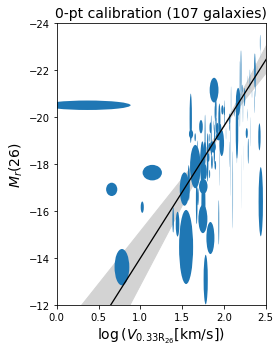

In [45]:
#sigmas = hf.get_sigmas()
xvals = np.linspace(0, 3, 1000)
yvals = m_fit * xvals + b_fit

# Calculate all of the best fits
yvals_random = []
for i in range(N_samples):
    yvals_random.append(xvals*m_random[i] + b_fit_array[i])
    #yvals_random.append(xvals*m_fit + b_fit_array[i])
yvals_random = np.asarray(yvals_random)
edges = np.nanpercentile(yvals_random, [16, 84], axis=0)

# Pack info into data
data = [np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']]
x_err = 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']
y_err = SGA_0pt['R_ABSMAG_SB26_err']
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
# Make the plot
'''
fig = plt.figure(figsize=(3,5))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
'''
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, edges[0], edges[1], color="lightgray")
#ax.fill_between(xvals, xvals-std_dev, xvals+std_dev, color='lightgray')
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$M_r(26)$", fontsize=14)
ax.set_title("0-pt calibration ({} galaxies)".format(len(SGA_0pt)), fontsize = 14)
ax.set_xlim(0, 2.5)
ax.set_ylim(-12, -24)
'''
# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap=cm.winter),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)
''';

#plt.savefig('../../Figures/SV/fuji_0pt_TFR_20230126.png', dpi=150)

### Fit w/ S/N > 10 and $W_{mx} > 64$ km/s

These are the requirements used in Cosmicflows-4

In [46]:
StoN = SGA_0pt['V_HI']/SGA_0pt['VERR_HI']

CF4_boolean = (StoN > 10) & ((SGA_0pt['V_HI_corr'] - 6) > 64)

In [47]:
b0_guess = -6.5

# Segev recommends that we generate a bunch of slopes based on its uncertainty, and run the fit a bunch of times.
m_fit = -5.63
m_fit_err = 1.16

N_samples = 100000

rng = np.random.default_rng()
m_random = rng.normal(m_fit, m_fit_err, size=N_samples)

b_fit_array_CF4 = np.nan*np.ones(N_samples)

# Fit for b using the actual slope
result = minimize(calculate_chi2, 
                  b0_guess, 
                  args=(m_fit, 
                        np.log10(SGA_0pt['V_0p33R26'][CF4_boolean]), 
                        0.434*SGA_0pt['V_0p33R26_err'][CF4_boolean]/SGA_0pt['V_0p33R26'][CF4_boolean], 
                        SGA_0pt['R_ABSMAG_SB26'][CF4_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_err'][CF4_boolean]), 
                  bounds=[[-19, 0]])
b_fit_CF4 = result.x[0]

for i in range(N_samples):
    result = minimize(calculate_chi2, 
                      b0_guess, 
                      args=(m_random[i], 
                            np.log10(SGA_0pt['V_0p33R26'][CF4_boolean]), 
                            0.434*SGA_0pt['V_0p33R26_err'][CF4_boolean]/SGA_0pt['V_0p33R26'][CF4_boolean], 
                            SGA_0pt['R_ABSMAG_SB26'][CF4_boolean], 
                            SGA_0pt['R_ABSMAG_SB26_err'][CF4_boolean]), 
                      bounds=[[-19, 0]])
    
    if result.success:
        b_fit_array_CF4[i] = result.x[0]

In [48]:
b_fit_CF4_err = np.nanstd(b_fit_array_CF4)

print('{:6.2f} +/- {:.2f}'.format(b_fit_CF4, b_fit_CF4_err))

 -8.41 +/- 2.32


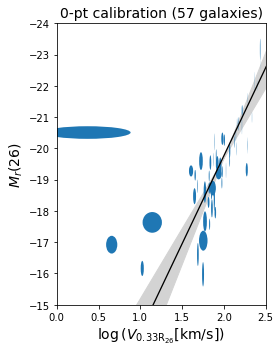

In [52]:
xvals = np.linspace(0, 3, 1000)
yvals = m_fit * xvals + b_fit_SN

# Calculate all of the best fits
yvals_random = []
for i in range(N_samples):
    yvals_random.append(xvals*m_random[i] + b_fit_array_CF4[i])
yvals_random = np.asarray(yvals_random)
edges = np.nanpercentile(yvals_random, [16, 84], axis=0)

# Pack info into data
data = [np.log10(SGA_0pt['V_0p33R26'][CF4_boolean]), SGA_0pt['R_ABSMAG_SB26'][CF4_boolean]]
x_err = 0.434*SGA_0pt['V_0p33R26_err'][CF4_boolean]/SGA_0pt['V_0p33R26'][CF4_boolean]
y_err = SGA_0pt['R_ABSMAG_SB26_err'][CF4_boolean]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, edges[0], edges[1], color="lightgray")

for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')

ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$M_r(26)$", fontsize=14)
ax.set_title("0-pt calibration ({} galaxies)".format(len(SGA_0pt[CF4_boolean])), fontsize = 14)
ax.set_xlim(0, 2.5)
ax.set_ylim(-15, -24)
'''
# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap=cm.winter),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)
''';

plt.savefig('../../Figures/SV/fuji_0pt_CF4_TFR_20230307.png', dpi=150)